In [ ]:
import os
from google.colab import drive

# 🔹 Montar Google Drive
drive.mount('/content/drive')

# 🔹 Número de fiecheros en un directorio
dir_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos"
num_files = len(os.listdir(dir_path))

print(f"Número de archivos en el directorio: {num_files}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Número de archivos en el directorio: 349


In [ ]:
# 🔹 Número de fiecheros en un directorio
dir_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted"
num_files = len(os.listdir(dir_path))

print(f"Número de archivos en el directorio: {num_files}")


Número de archivos en el directorio: 349


In [ ]:
# VER EL CONTENIDO DE UN DIRECTORIO Y DE TODOS LOS FICHEROS

import os
from google.colab import drive

# 🔹 Montar Google Drive
drive.mount('/content/drive')


dir_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"

# Obtener todas las carpetas dentro del directorio
for folder in sorted(os.listdir(dir_path)):
    folder_path = os.path.join(dir_path, folder)

    if os.path.isdir(folder_path):  # Verifica si es una carpeta
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{folder}: {num_files} archivos")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Distracted_Look: 133 archivos
Eyes_Closed: 1382 archivos
Eyes_Open: 2087 archivos
Focused_Look: 3098 archivos
Head_Nodding: 234 archivos
Head_Stable: 10721 archivos
Non_Yawning: 4306 archivos
Yawning: 3486 archivos


In [ ]:
import torch
print("✅ GPU disponible:", torch.cuda.is_available())
print("🔹 Nombre de la GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "❌ No hay GPU disponible")


✅ GPU disponible: True
🔹 Nombre de la GPU: NVIDIA A100-SXM4-40GB


In [ ]:
import time
import os

def check_gpu():
    !nvidia-smi
    gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
    return gpu_info[0] if gpu_info else "No GPU"

max_attempts = 10  # Número máximo de intentos
attempt = 0

while attempt < max_attempts:
    gpu_name = check_gpu()
    print(f"Intento {attempt + 1}: GPU asignada -> {gpu_name}")

    if "A100" in gpu_name:
        print("🎉 ¡Éxito! Se ha asignado una GPU A100.")
        break  # Sale del bucle si encuentra una A100
    else:
        print("⚠ No se asignó una A100. Reiniciando entorno...")
        time.sleep(5)
        os.system("kill -9 -1")  # Reinicia el entorno y fuerza una nueva asignación

print("✅ Proceso finalizado.")

Sun Feb 16 10:51:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import torch
print("✅ GPU con CUDA disponible:", torch.cuda.is_available())
print("🔹 Nombre de la GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "❌ No hay GPU con CUDA disponible")


✅ GPU con CUDA disponible: True
🔹 Nombre de la GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# CALIDAD DE LAS IMAGENES EXTRAIDAS

import os
import cv2
import dlib
import numpy as np
import pandas as pd
import torch
import time
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from imutils import face_utils
from google.colab import drive

# 📌 Verificar si GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Procesamiento en: {device}")

# 📌 Montar Google Drive
drive.mount('/content/drive')

# 📌 Ruta base del dataset
base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"

# 📌 Verificar si el modelo de landmarks está disponible
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

if not os.path.exists(predictor_path):
    print("❌ Modelo de landmarks no encontrado. Descargando automáticamente...")
    !wget -O shape_predictor_68_face_landmarks.dat.bz2 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
    !mv shape_predictor_68_face_landmarks.dat /content/drive/MyDrive/
    print("✅ Modelo descargado y guardado en Google Drive.")

# 📌 Cargar el detector de rostros y los landmarks faciales
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
print(f"✅ Detector y predictor cargados en {device}")

# 📌 Funciones para calcular MAR, EAR, Head Tilt y Gaze Angle
def compute_mar(mouth):
    A = np.linalg.norm(mouth[2] - mouth[10])
    B = np.linalg.norm(mouth[4] - mouth[8])
    C = np.linalg.norm(mouth[0] - mouth[6])
    return (A + B) / (2.0 * C)

def compute_ear(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

def compute_head_tilt(nose, chin):
    delta_x = chin[0] - nose[0]
    delta_y = chin[1] - nose[1]
    return abs(np.arctan2(delta_y, delta_x) * (180.0 / np.pi))

def compute_gaze_angle(eye):
    return np.mean(eye, axis=0)[0]

# 📌 Obtener lista de imágenes
image_paths = []
for category in os.listdir(base_path):
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_paths.append((image_name, category, os.path.join(category_path, image_name)))

total_images = len(image_paths)
print(f"📌 Total de imágenes a procesar: {total_images}")

# 📌 Función para procesar una imagen
def analizar_imagen(image_info):
    image_name, category, image_path = image_info
    image = cv2.imread(image_path)
    if image is None:
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        return None

    for face in faces:
        shape = predictor(gray, face)
        shape = face_utils.shape_to_np(shape)

        # Landmarks de la boca, ojos y nariz
        mouth = shape[48:68]
        left_eye = shape[36:42]
        right_eye = shape[42:48]
        nose = shape[27]
        chin = shape[8]

        # Calcular métricas
        mar = compute_mar(mouth)
        ear = (compute_ear(left_eye) + compute_ear(right_eye)) / 2.0
        head_tilt = compute_head_tilt(nose, chin)
        gaze_angle = (compute_gaze_angle(left_eye) + compute_gaze_angle(right_eye)) / 2.0

        # Calcular nitidez, brillo y contraste
        laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
        brightness = np.mean(gray)
        contrast = gray.std()

        # Determinar calidad
        calidad = "Buena" if laplacian > 100 else "Mala"

        # Retornar resultados
        return [image_name, category, laplacian, brightness, contrast, calidad, mar, ear, head_tilt, gaze_angle]

# 📌 Procesamiento con Multiprocesamiento
num_procesos = min(cpu_count(), 8)  # Usa hasta 8 núcleos
start_time = time.time()

with Pool(num_procesos) as p:
    results = list(tqdm(p.imap(analizar_imagen, image_paths), total=total_images, desc="🟢 Procesando imágenes", unit="img"))

# 📌 Filtrar resultados válidos
results = [r for r in results if r is not None]

# 📌 Crear DataFrame
df = pd.DataFrame(results, columns=["Imagen", "Categoria", "Nitidez (Laplace)", "Brillo", "Contraste", "Calidad", "MAR (Bostezos)", "EAR (Ojos Cerrados)", "Head Tilt (Cabeza)", "Gaze Angle (Mirada)"])

# 📌 Guardar en un CSV
csv_output_path = os.path.join(base_path, "reporte_calidad_imagenes_optimizado.csv")
df.to_csv(csv_output_path, index=False)

# 📌 Mostrar resumen final con barra de progreso
elapsed_time = time.time() - start_time
print(f"\n✅ Evaluación completada en {elapsed_time / 60:.2f} minutos. CSV guardado en: {csv_output_path}")

# 📌 Mostrar las primeras filas del DataFrame
display(df.head(20))





✅ Procesamiento en: cuda
Mounted at /content/drive
✅ Detector y predictor cargados en cuda
📌 Total de imágenes a procesar: 43961


🟢 Procesando imágenes: 100%|██████████| 43961/43961 [55:39<00:00, 13.16img/s]



✅ Evaluación completada en 55.67 minutos. CSV guardado en: /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_imagenes_optimizado.csv


,Imagen,Categoria,Nitidez (Laplace),Brillo,Contraste,Calidad,MAR (Bostezos),EAR (Ojos Cerrados),Head Tilt (Cabeza),Gaze Angle (Mirada)
0,44-MaleNoGlasses-Yawning.mp4_frame_700.jpg,Eyes_Closed,374.263831,113.924290,79.256482,Buena,0.166660,0.199564,101.309932,380.666667
1,44-MaleNoGlasses-Yawning.mp4_frame_710.jpg,Eyes_Closed,372.654784,116.902122,79.164109,Buena,0.154791,0.181514,99.987422,371.333333
2,44-MaleNoGlasses-Yawning.mp4_frame_720.jpg,Eyes_Closed,363.300116,118.710918,78.784514,Buena,0.236000,0.198296,98.691308,317.333333
3,45-MaleNoGlasses-Normal.mp4_frame_0.jpg,Eyes_Closed,519.807170,116.614300,66.507283,Buena,0.287763,0.204824,101.056413,361.000000
4,45-MaleNoGlasses-Normal.mp4_frame_90.jpg,Eyes_Closed,557.559938,117.531715,67.609059,Buena,0.303209,0.211970,98.031656,406.416667
5,45-MaleNoGlasses-Normal.mp4_frame_300.jpg,Eyes_Closed,512.591094,126.178545,68.994115,Buena,0.249352,0.189209,75.618605,309.583333
6,45-MaleNoGlasses-Normal.mp4_frame_310.jpg,Eyes_Closed,553.086731,124.844326,68.582649,Buena,0.195413,0.180987,75.797441,312.083333
7,45-MaleNoGlasses-Normal.mp4_frame_320.jpg,Eyes_Closed,515.180449,119.246855,68.394125,Buena,0.174552,0.186658,75.323607,313.916667
8,45-MaleNoGlasses-Normal.mp4_frame_330.jpg,Eyes_Closed,491.592948,113.730111,67.993863,Buena,0.221497,0.207268,77.780687,327.250000
9,45-MaleNoGlasses-Normal.mp4_frame_440.jpg,Eyes_Closed,521.358018,112.816846,66.416134,Buena,0.271367,0.110243,94.504907,369.000000


In [ ]:
import pandas as pd

# 📌 Ruta del CSV
csv_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_imagenes_optimizado.csv"

# 📌 Cargar el dataset
df = pd.read_csv(csv_path)

# 📌 Mostrar primeras filas
print("🔹 Primeras filas del dataset:")
display(df.head())

# 📌 Resumen de la cantidad de imágenes por categoría
print("\n📌 Cantidad de imágenes por categoría:")
display(df["Categoria"].value_counts())

# 📌 Resumen de la cantidad de imágenes por calidad
print("\n📌 Cantidad de imágenes por calidad:")
display(df["Calidad"].value_counts())


🔹 Primeras filas del dataset:


,Imagen,Categoria,Nitidez (Laplace),Brillo,Contraste,Calidad,MAR (Bostezos),EAR (Ojos Cerrados),Head Tilt (Cabeza),Gaze Angle (Mirada)
0,44-MaleNoGlasses-Yawning.mp4_frame_700.jpg,Eyes_Closed,374.263831,113.924290,79.256482,Buena,0.166660,0.199564,101.309932,380.666667
1,44-MaleNoGlasses-Yawning.mp4_frame_710.jpg,Eyes_Closed,372.654784,116.902122,79.164109,Buena,0.154791,0.181514,99.987422,371.333333
2,44-MaleNoGlasses-Yawning.mp4_frame_720.jpg,Eyes_Closed,363.300116,118.710918,78.784514,Buena,0.236000,0.198296,98.691308,317.333333
3,45-MaleNoGlasses-Normal.mp4_frame_0.jpg,Eyes_Closed,519.807170,116.614300,66.507283,Buena,0.287763,0.204824,101.056413,361.000000
4,45-MaleNoGlasses-Normal.mp4_frame_90.jpg,Eyes_Closed,557.559938,117.531715,67.609059,Buena,0.303209,0.211970,98.031656,406.416667



📌 Cantidad de imágenes por categoría:


,count
Categoria,
Eyes_Open,19480
Focused_Look,19466
Eyes_Closed,2290
Head_Nodding,1592
Distracted_Look,707



📌 Cantidad de imágenes por calidad:


,count
Calidad,
Buena,43535


In [ ]:
# 📌 Filtrar imágenes de alta calidad
df_filtered = df[df["Calidad"] == "Buena"]

# 📌 Guardar el nuevo dataset limpio
csv_cleaned_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_limpio.csv"
df_filtered.to_csv(csv_cleaned_path, index=False)

print(f"✅ Dataset filtrado guardado en: {csv_cleaned_path}")


✅ Dataset filtrado guardado en: /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_limpio.csv


<Axes: >

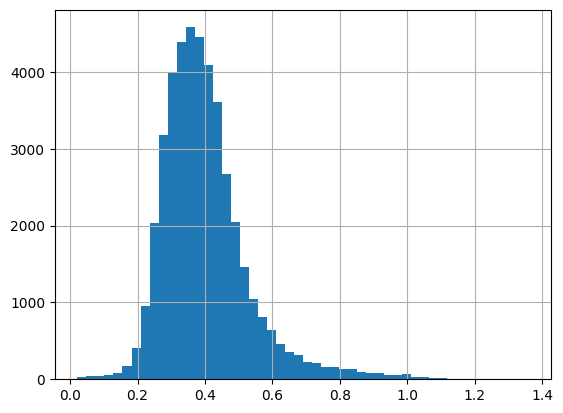

In [ ]:
# 📌 Verificar si hay imágenes con valores extremos de MAR (bostezos) en la categoría equivocada
df_filtered["MAR (Bostezos)"].hist(bins=50)


In [ ]:
import shutil

# 📌 Directorio base de frames
frames_dir = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/"

# 📌 Definir umbral de MAR para bostezos
mar_threshold = 0.5

# 📌 Filtrar imágenes que deberían estar en la categoría "Yawning"
df_bostezos = df_filtered[(df_filtered["MAR (Bostezos)"] > mar_threshold) & (df_filtered["Categoria"] != "Yawning")]

# 📌 Mover imágenes mal clasificadas
for _, row in df_bostezos.iterrows():
    old_path = os.path.join(frames_dir, row["Categoria"], row["Imagen"])
    new_path = os.path.join(frames_dir, "Yawning", row["Imagen"])

    if os.path.exists(old_path):
        shutil.move(old_path, new_path)

print(f"✅ {len(df_bostezos)} imágenes movidas a la categoría correcta: Yawning")


✅ 6973 imágenes movidas a la categoría correcta: Yawning


In [ ]:
import pandas as pd

# 📌 Ruta del CSV con la información de calidad
csv_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_imagenes_optimizado.csv"

# 📌 Cargar el dataset
df = pd.read_csv(csv_path)

# 📌 Buscar imágenes con MAR bajo (pocos bostezos) para "Non_Yawning"
umbral_mar = 0.3  # Un valor bajo de MAR indica que no hay bostezo
df_no_yawning = df[(df["MAR (Bostezos)"] < umbral_mar) & (df["Categoria"] != "Non_Yawning")]

# 📌 Buscar imágenes con EAR estable para "Head_Stable"
umbral_ear = 0.25  # Un valor medio-bajo de EAR indica que los ojos no están cerrándose
df_head_stable = df[(df["EAR (Ojos Cerrados)"] > umbral_ear) & (df["Categoria"] != "Head_Stable")]

# 📌 Mostrar cuántas imágenes podrían reubicarse
print(f"🔹 Imágenes que podrían moverse a 'Non_Yawning': {len(df_no_yawning)}")
print(f"🔹 Imágenes que podrían moverse a 'Head_Stable': {len(df_head_stable)}")


🔹 Imágenes que podrían moverse a 'Non_Yawning': 8612
🔹 Imágenes que podrían moverse a 'Head_Stable': 33053


In [ ]:
import os
import shutil

# 📌 Directorio base de frames
frames_dir = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/"

# 📌 Función para mover imágenes
def mover_imagenes(df, categoria_destino):
    destino = os.path.join(frames_dir, categoria_destino)
    os.makedirs(destino, exist_ok=True)

    movidas = 0
    for _, row in df.iterrows():
        origen = os.path.join(frames_dir, row["Categoria"], row["Imagen"])
        destino_path = os.path.join(destino, row["Imagen"])

        if os.path.exists(origen):  # Verifica que la imagen exista antes de moverla
            shutil.move(origen, destino_path)
            movidas += 1

    print(f"✅ {movidas} imágenes movidas a {categoria_destino}")

# 📌 Mover imágenes detectadas a "Non_Yawning"
mover_imagenes(df_no_yawning, "Non_Yawning")

# 📌 Mover imágenes detectadas a "Head_Stable"
mover_imagenes(df_head_stable, "Head_Stable")

print("🚀 Proceso de reorganización de imágenes completado.")


✅ 8612 imágenes movidas a Non_Yawning
✅ 21442 imágenes movidas a Head_Stable
🚀 Proceso de reorganización de imágenes completado.


In [ ]:
!ls -lh /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/Non_Yawning
print()
!ls -lh /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/Head_Stable

Se han truncado las últimas 5000 líneas del flujo de salida.
-rw------- 1 root root  77K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_400.jpg
-rw------- 1 root root  73K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_410.jpg
-rw------- 1 root root  71K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_420.jpg
-rw------- 1 root root  73K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_450.jpg
-rw------- 1 root root  75K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_470.jpg
-rw------- 1 root root  73K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_480.jpg
-rw------- 1 root root  80K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_490.jpg
-rw------- 1 root root  73K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_500.jpg
-rw------- 1 root root  79K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_520.jpg
-rw------- 1 root root  75K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_540.jpg
-rw------- 1 root root  80K Feb 16 08:03  30-MaleGlasses-Normal.mp4_frame_560.jpg
-rw------- 1 root root  80K Feb 16 08

In [ ]:
import pandas as pd

# 📌 Cargar el dataset de calidad para ver las imágenes de "Non_Yawning"
csv_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_imagenes_optimizado.csv"
df = pd.read_csv(csv_path)

# 📌 Verificar si las imágenes siguen en sus categorías originales
for img in df[df["Categoria"] == "Non_Yawning"]["Imagen"]:
    old_path = os.path.join(frames_dir, "Yawning", img)  # Antes estaba en Yawning
    if os.path.exists(old_path):
        print(f"❗ Imagen aún en la carpeta original: {old_path}")


In [ ]:
import os
from google.colab import drive

# 📌 Montar Google Drive
drive.mount('/content/drive')

# 📌 Directorio base donde deberían estar las imágenes
frames_dir = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"

# 📌 Verificar contenido de cada carpeta
for category in os.listdir(frames_dir):
    category_path = os.path.join(frames_dir, category)
    if os.path.isdir(category_path):
        num_files = len(os.listdir(category_path))
        print(f"📂 {category}: {num_files} archivos")


Mounted at /content/drive
📂 Yawning: 3486 archivos
📂 Non_Yawning: 4306 archivos
📂 Eyes_Closed: 1382 archivos
📂 Eyes_Open: 2087 archivos
📂 Head_Nodding: 234 archivos
📂 Head_Stable: 10721 archivos
📂 Distracted_Look: 133 archivos
📂 Focused_Look: 9177 archivos


In [ ]:
!sync


In [ ]:
!ls -R /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames


Se han truncado las últimas 5000 líneas del flujo de salida.
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_530.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_540.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_550.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_560.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_570.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_580.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_590.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_600.jpg'
'36-FemaleNoGlasses-Talking&Yawning.mp4_frame_90.jpg'
 36-FemaleNoGlasses-Yawning.mp4_frame_0.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_100.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_110.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_140.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_150.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_170.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_180.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_250.jpg
 36-FemaleNoGlasses-Yawning.mp4_frame_260.jpg
 36-FemaleNoGlasses-Yawning.mp4_f

In [ ]:
import os
import random

# Directorios donde deberían estar las imágenes
base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"

# Categorías a verificar
categories_to_check = ["Non_Yawning", "Head_Stable"]

# Buscar imágenes en cada categoría
image_samples = {}

for category in categories_to_check:
    category_path = os.path.join(base_path, category)

    if os.path.isdir(category_path):
        files = os.listdir(category_path)

        if files:
            # Seleccionar una imagen al azar de la categoría
            sample_image = random.choice(files)
            image_samples[category] = os.path.join(category_path, sample_image)
        else:
            image_samples[category] = "❌ No hay imágenes en esta carpeta."
    else:
        image_samples[category] = "🚫 La carpeta no existe."

# Mostrar resultados
for category, image_path in image_samples.items():
    print(f"📂 {category}: {image_path}")


📂 Non_Yawning: /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/Non_Yawning/40-MaleNoGlasses-Yawning.mp4_frame_450.jpg
📂 Head_Stable: /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/Head_Stable/4-FemaleGlasses-Talking.mp4_frame_590.jpg


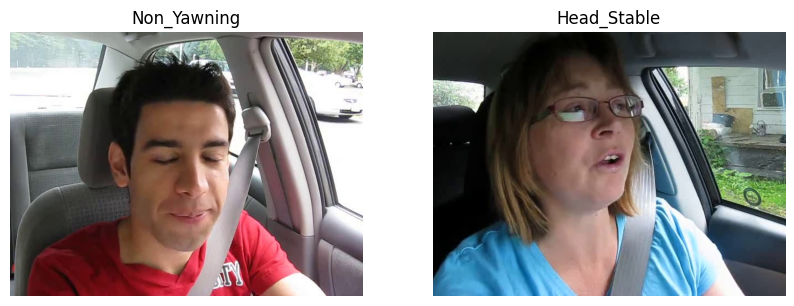

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 📌 Rutas de las imágenes identificadas
image_paths = {
    "Non_Yawning": "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/Non_Yawning/40-MaleNoGlasses-Yawning.mp4_frame_450.jpg",
    "Head_Stable": "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/Head_Stable/4-FemaleGlasses-Talking.mp4_frame_590.jpg"
}

# 📌 Mostrar las imágenes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx, (category, image_path) in enumerate(image_paths.items()):
    image = cv2.imread(image_path)  # Leer la imagen
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        axes[idx].imshow(image)
        axes[idx].set_title(category)
        axes[idx].axis("off")
    else:
        print(f"❌ No se pudo abrir la imagen en {category}")

plt.show()


In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # Desmontar Drive para sincronizar cambios
drive.mount('/content/drive', force_remount=True)  # Volver a montarlo


In [ ]:
import pandas as pd
import os
from IPython.display import display

# Ruta del archivo en Google Drive
csv_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames/reporte_calidad_imagenes_optimizado.csv"

# Verificar si el archivo existe
if not os.path.exists(csv_path):
    print(f"⚠ No se encontró el archivo en {csv_path}")
else:
    # Cargar el archivo CSV
    df = pd.read_csv(csv_path)

    # Contar el número de imágenes por categoría
    category_counts = df["Categoria"].value_counts().reset_index()
    category_counts.columns = ["Categoría", "Número de Imágenes"]

    # Contar el número de imágenes por calidad (Buena/Mala)
    quality_counts = df["Calidad"].value_counts().reset_index()
    quality_counts.columns = ["Calidad", "Número de Imágenes"]

    # Mostrar las tablas con los datos
    print("📌 Número de imágenes por categoría:")
    display(category_counts)

    print("\n📌 Número de imágenes por calidad:")
    display(quality_counts)




📌 Número de imágenes por categoría:


,Categoría,Número de Imágenes
0,Eyes_Open,19480
1,Focused_Look,19466
2,Eyes_Closed,2290
3,Head_Nodding,1592
4,Distracted_Look,707



📌 Número de imágenes por calidad:


,Calidad,Número de Imágenes
0,Buena,43535


In [ ]:
import os
import pandas as pd

# 📌 Rutas de trabajo
base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"
csv_path = os.path.join(base_path, "reporte_calidad_imagenes_optimizado.csv")

# 📌 Cargar el dataset con los valores de MAR y EAR
df = pd.read_csv(csv_path)

# 📌 Definir los umbrales actuales
MAR_THRESHOLD = 0.4  # Ajustar si es necesario
EAR_THRESHOLD = 0.2  # Ajustar si es necesario

# 📌 Filtrar imágenes sospechosas
suspicious_yawning = df[(df["Categoria"] == "Non_Yawning") & (df["MAR"] > MAR_THRESHOLD)]
suspicious_non_yawning = df[(df["Categoria"] == "Yawning") & (df["MAR"] < MAR_THRESHOLD)]
suspicious_eyes_open = df[(df["Categoria"] == "Eyes_Closed") & (df["EAR"] > EAR_THRESHOLD)]
suspicious_eyes_closed = df[(df["Categoria"] == "Eyes_Open") & (df["EAR"] < EAR_THRESHOLD)]

# 📌 Unir todas las imágenes sospechosas
df_suspicious = pd.concat([
    suspicious_yawning,
    suspicious_non_yawning,
    suspicious_eyes_open,
    suspicious_eyes_closed
])

# 📌 Guardar el reporte de imágenes sospechosas
suspicious_csv_path = os.path.join(base_path, "reporte_imagenes_sospechosas.csv")
df_suspicious.to_csv(suspicious_csv_path, index=False)

# 📌 Mostrar el reporte de imágenes sospechosas
print(f"📌 Se han detectado {len(df_suspicious)} imágenes con posible clasificación incorrecta.")
display(df_suspicious.head(20))  # Mostrar solo las primeras 20 para inspección rápida


KeyError: 'MAR'

In [ ]:
import os
import shutil
import pandas as pd

# Ruta base
base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD"
frames_path = os.path.join(base_path, "Frames")
csv_path = os.path.join(base_path, "reporte_calidad_imagenes.csv")

# Leer el CSV con la clasificación
df = pd.read_csv(csv_path)

# Definir las categorías a mover
categories_to_move = ["Focused_Look", "Head_Nodding", "Distracted_Look"]

# Crear las carpetas si no existen
for category in categories_to_move:
    category_folder = os.path.join(frames_path, category)
    os.makedirs(category_folder, exist_ok=True)

# Mover las imágenes a sus carpetas correspondientes
moved_files = 0
for index, row in df.iterrows():
    image_name = row["Imagen"]
    category = row["Categoria"]

    if category in categories_to_move:
        source_path = os.path.join(frames_path, image_name)
        destination_folder = os.path.join(frames_path, category)
        destination_path = os.path.join(destination_folder, image_name)

        if os.path.exists(source_path):
            shutil.move(source_path, destination_path)
            moved_files += 1

print(f"✅ Se han movido {moved_files} imágenes a sus carpetas correspondientes.")


✅ Se han movido 0 imágenes a sus carpetas correspondientes.


In [ ]:
# VERIFICAR LA SALUD DE LOS FICHEROS DE VIDEO

import cv2
import os

videos_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted"

error_videos = []

for video_file in os.listdir(videos_path):
    video_path = os.path.join(videos_path, video_file)

    if not video_file.lower().endswith(".mp4"):
        continue  # Omitir archivos que no sean .mp4

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"⚠ No se pudo abrir el video: {video_file}")
        error_videos.append(video_file)
    else:
        print(f"✅ Video verificado: {video_file}")

    cap.release()

if error_videos:
    print(f"🚨 Hay {len(error_videos)} videos que aún no se pueden abrir: {error_videos}")
else:
    print("🎉 Todos los videos convertidos son accesibles y listos para el procesamiento.")


✅ Video verificado: 23-MaleNoGlasses-Talking.mp4
✅ Video verificado: 38-MaleSunGlasses-Yawning.mp4
✅ Video verificado: 38-MaleSunGlasses-Normal.mp4
✅ Video verificado: 36-MaleSunGlasses-Talking.mp4
✅ Video verificado: 38-MaleNoGlasses-Yawning.mp4
✅ Video verificado: 28-MaleNoGlasses-Normal.mp4
✅ Video verificado: 38-MaleNoGlasses-Normal.mp4
✅ Video verificado: 39-MaleGlasses-Talking.mp4
✅ Video verificado: 38-MaleNoGlasses-Talking.mp4
✅ Video verificado: 36-MaleSunGlasses-Yawning.mp4
✅ Video verificado: 31-MaleGlasses-Normal.mp4
✅ Video verificado: 40-MaleNoGlasses-Yawning.mp4
✅ Video verificado: 39-MaleGlasses-Normal.mp4
✅ Video verificado: 41-MaleNoGlasses-Yawning.mp4
✅ Video verificado: 37-MaleNoGlasses-Talking.mp4
✅ Video verificado: 3-MaleGlasses-Yawning.mp4
✅ Video verificado: 39-MaleGlasses-Yawning.mp4
✅ Video verificado: 29-MaleNoGlasses-Normal.mp4
✅ Video verificado: 40-MaleNoGlasses-Normal.mp4
✅ Video verificado: 28-MaleGlasses-Yawning.mp4
✅ Video verificado: 31-MaleGlasses-T